In [1]:
import skeliner as sk

import matplotlib.pyplot as plt

This notebook shows how to find contact sites between two neurons from Eyewire II. 

We will first find all putative contact positions with the skeletons (assuming the radii of all nodes are robustly estimated). Then, we will use those positions as seeds to extract the contact site faces from the corresponding meshes and calculate the area of each site.

### Find contact seeds between skeleton A and B

In [2]:
dsgc = sk.io.load_npz("../../data/DSGC/720575940567182923/skeleton.npz")
sac_off = sk.io.load_npz("../../data/SAC-OFF/720575940572154471/skeleton.npz")

In [3]:
contact_seeds = sk.pair.find_contact_seeds(dsgc, sac_off)

print(f"# contact seeds (from skeletons) = {len(contact_seeds.pos)}")

# contact seeds (from skeletons) = 82


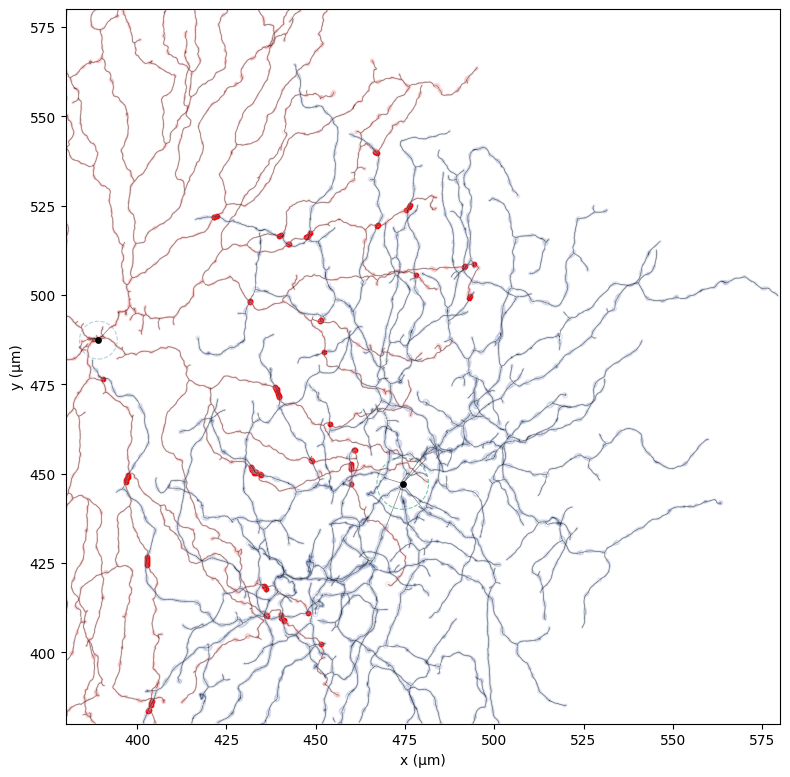

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sk.plot2d(sac_off, color_by="ntype", skel_cmap="Paired", ax=ax, xlim=(380, 580), ylim=(380, 580))
sk.plot2d(dsgc, color_by="ntype", skel_cmap="Set2", ax=ax, xlim=(380, 580), ylim=(380, 580))

plt.scatter(contact_seeds.pos[:, 0], contact_seeds.pos[:, 1], color="red", s=10)


### Using the seeds to find contact sites on mesh A and B

In [5]:
dsgc_mesh = sk.io.load_mesh("../../data/DSGC/720575940567182923/mesh.obj")
sac_off_mesh = sk.io.load_mesh("../../data/SAC-OFF/720575940572154471/mesh.obj")

contact_sites = sk.pair.map_contact_sites(
    dsgc_mesh, sac_off_mesh, 
    contact_seeds.pos * 1000.0 # unit: nm
)

print(f"# mapped contact sites (from meshes): {len(contact_sites.area_A)}, total area: {contact_sites.area_A.sum() * 1e-6} um^2")

# mapped contact sites (from meshes): 32, total area: 13.928256023442204 um^2


In [6]:
contact_sites.area_A * 1e-6

array([1.15394108, 0.70949342, 0.74908076, 0.88683408, 0.69671071,
       0.04776205, 0.22110228, 0.11470915, 0.44173302, 1.0064391 ,
       0.32966614, 0.3376796 , 0.22335312, 0.80127101, 1.57423554,
       0.16925257, 0.52331199, 0.52446789, 0.17649908, 0.07302392,
       0.11372621, 0.19136563, 0.20633399, 0.25721735, 0.20402571,
       0.73951546, 0.22925671, 0.04008333, 0.0193548 , 0.25746198,
       0.43475128, 0.47459707])

In [7]:
print(f"# contact seeds (from skeletons): {len(contact_seeds.pos)}")
print(f"# mapped contact sites (from meshes): {len(contact_sites.seeds_A)}, total area = {contact_sites.area_A.sum() * 1e-6} um^2")

# contact seeds (from skeletons): 82
# mapped contact sites (from meshes): 32, total area = 13.928256023442204 um^2


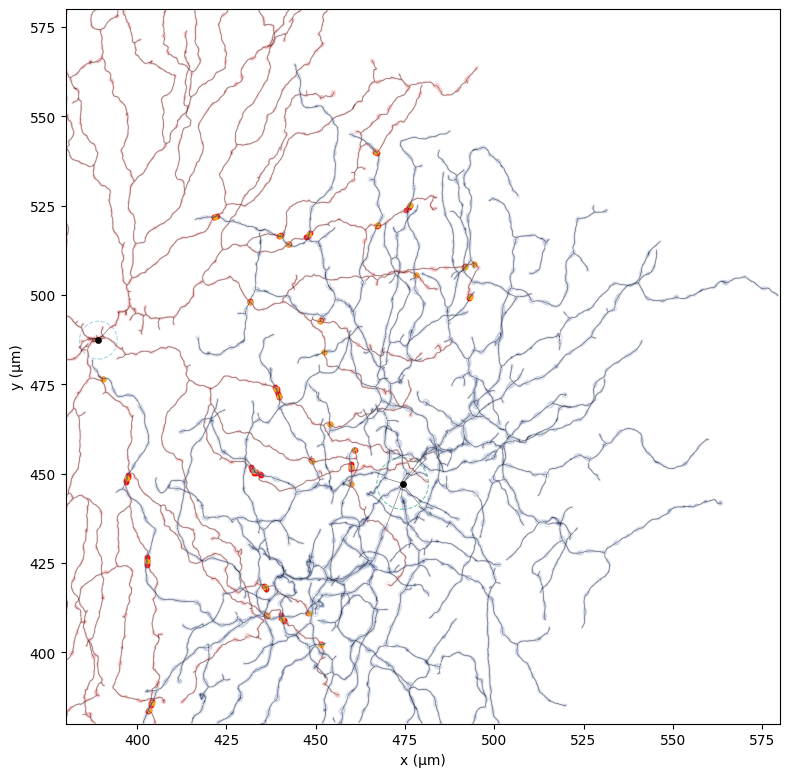

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sk.plot2d(sac_off, color_by="ntype", skel_cmap="Paired", ax=ax, xlim=(380, 580), ylim=(380, 580))
sk.plot2d(dsgc, color_by="ntype", skel_cmap="Set2", ax=ax, xlim=(380, 580), ylim=(380, 580))

plt.scatter(contact_seeds.pos[:, 0], contact_seeds.pos[:, 1], color="red", s=10)
plt.scatter(contact_sites.seeds_A[:, 0]/1000, contact_sites.seeds_A[:, 1]/1000, color="orange", s=10)


### Compute stats to filter contact sites

In [9]:
contact_sites_with_stats = sk.pair.compute_contact_stats(dsgc_mesh, sac_off_mesh, contact_sites)

# all filters are None by default, you can set just one or multiple criteria to filter the sites
contact_sites_filtered = sk.pair.filter_contact_sites(
      contact_sites_with_stats,
      area_min=None, 
      area_max=None, 
      aspect_max=6.0,              # reject very elongated (band-like) patches
      roundness_min=0.25,          # prefer compact blobs
      normal_opposition_max=-0.2,  # ensure reasonably opposed surfaces
      faces_min=3,
      normal_dispersion_max=0.8    # avoid noisy/fragmented patches
) 

In [10]:
contact_sites_filtered.meta["filter"]

{'kept': 29,
 'total': 32,
 'mask': array([ True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]),
 'area_min': None,
 'area_max': None,
 'aspect_max': 6.0,
 'roundness_min': 0.25,
 'normal_opposition_max': -0.2,
 'faces_min': 3,
 'normal_dispersion_max': 0.8}

In [11]:
{ # Here are the patches that are filtered out because they are too elongated 
    key:contact_sites.stats_A[key][~contact_sites_filtered.meta["filter"]["mask"]] 
        for key in contact_sites.stats_A.keys()
}

{'extent_long': array([3018.42120087, 2556.8176667 , 1128.13885676]),
 'extent_short': array([336.5224591 , 334.51105609, 168.88039064]),
 'aspect': array([8.9694495 , 7.64344741, 6.68010568]),
 'roundness': array([0.25807651, 0.28361703, 0.29819712]),
 'faces_count': array([152., 136.,  35.]),
 'normal_dispersion': array([0.44183746, 0.22432546, 0.17289255])}

### Save and load Contact Sites Result

In [12]:
# contact_sites.to_npz(path="../dev/temp_io/test_contact_sites.npz")
# contact_sites_loaded = sk.io.load_contact_sites_npz("../dev/temp_io/test_contact_sites.npz")

### View results in 3D viewer

In [13]:
# sk.plot.view_contacts(dsgc_mesh, sac_off_mesh, contact_sites, sides="A")

<div style="display:flex; gap:12px; flex-wrap:wrap">
  <img src="../.github/media/contacts-meshes-with-patches.png" style="max-width:30%; height:auto;">
  <img src="../.github/media/contacts-one-mesh-with-patches.png" style="max-width:30%; height:auto;">
  <img src="../.github/media/contacts-no-meshes-patches-only.png" style="max-width:30%; height:auto;">
</div>

### Bonus: Approximating the contact areas with the skeletons information only

There's a faster alternative to `map_contact_sites` which uses the spherical cap areas as the contact area substitute. The caveat is that there's no good way to verify the result. 

In [14]:
approx = sk.pair.approximate_contact_sites(
    dsgc, sac_off, seeds=contact_seeds,
    tol_nm=54, # from experience, this value is mostly around 50-55 for Eyewire II                   
    area_unit="um^2",
)
print(f"# approximated contact sites (from skeletons): {approx.meta['K_sites']}, total area: {approx.area_A.sum()}")
print(f"# mapped contact sites (from meshes): {len(contact_sites.seeds_A)}, total area = {contact_sites.area_A.sum() * 1e-6} um^2")

# approximated contact sites (from skeletons): 36, total area: 13.969447591262233
# mapped contact sites (from meshes): 32, total area = 13.928256023442204 um^2


In [15]:
approx.area_A

array([0.95437008, 0.44767254, 0.47817213, 0.27735202, 0.22870374,
       0.58991813, 0.15027153, 0.06636874, 0.08696895, 0.09183636,
       0.83517347, 0.23353446, 0.38754602, 0.58225878, 0.84442311,
       1.22924558, 0.73204994, 0.17684512, 0.42953382, 1.04141389,
       0.1322453 , 0.25681207, 0.28054705, 0.24160431, 0.24965848,
       0.0502339 , 0.19564626, 0.1759574 , 0.38180336, 0.13400265,
       0.23964405, 0.05267742, 0.16543826, 0.32733879, 0.81358681,
       0.40859306])

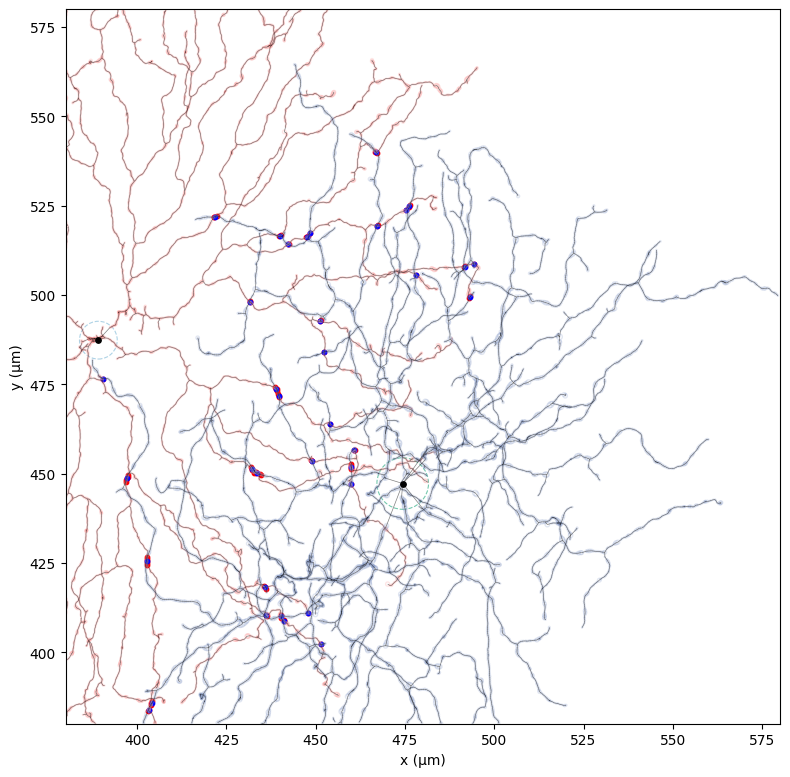

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sk.plot2d(sac_off, color_by="ntype", skel_cmap="Paired", ax=ax, xlim=(380, 580), ylim=(380, 580))
sk.plot2d(dsgc, color_by="ntype", skel_cmap="Set2", ax=ax, xlim=(380, 580), ylim=(380, 580))

plt.scatter(contact_seeds.pos[:, 0], contact_seeds.pos[:, 1], color="red", s=10)
plt.scatter(approx.center[:, 0], approx.center[:, 1], color="blue", s=10)

In [17]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-09-11 16:51:27CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

matplotlib: 3.10.3
skeliner  : 0.2.0

Watermark: 2.5.0

